In [1]:
import torch

if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print(f"Available GPUs: {device_count}")
    
    for i in range(device_count):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {gpu_name}")
else:
    print("No CUDA devices found.")

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print('Using: ', device)

Available GPUs: 4
GPU 0: NVIDIA A100 80GB PCIe
GPU 1: NVIDIA A100 80GB PCIe
GPU 2: NVIDIA A100 80GB PCIe
GPU 3: NVIDIA A100 80GB PCIe
Using:  cuda:2


In [2]:
from lib.dataset.dataset import get_dataloaders

train_loader, val_loader = get_dataloaders(data_root='../data/27kpng')

In [3]:
import torch
from lib.models.rirci import RIRCIModel 

def load_model_from_checkpoint(checkpoint_path):
    model = RIRCIModel(simple=True).to(device)
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
    
    return {
        'model': model,
        'optimizer': checkpoint['optimizer_state_dict'],
        'epoch': checkpoint['epoch'],
        'losses': checkpoint['losses']
    }

# Load the model
checkpoint_data = load_model_from_checkpoint(
    '/app/checkpoints/RIRCIModel-2025-05-10-090853/best_model.pth',
)

model = checkpoint_data['model']
model = model.to(device)
model.eval()

print('loaded')

/tmp/ipykernel_6424/3199234529.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded checkpoint from epoch 56
loaded


In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchmetrics.functional import peak_signal_noise_ratio as psnr
from torchmetrics.functional import structural_similarity_index_measure as ssim

def denormalize(tensor, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    """Denormalize a tensor image with mean and std"""
    # Clone to avoid modifying original
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Reverse normalization: (t * s) + m
    return tensor.clamp_(0, 1)  # Clamp to valid range

def visualize_random_samples(model, dataloader, device, num_samples=5):
    """
    Enhanced visualization with clear mask error display
    """
    model.eval()
    dataset = dataloader.dataset
    sample_indices = random.sample(range(len(dataset)), num_samples)
    samples = [dataset[i] for i in sample_indices]

    # Create figure with more columns for better mask comparison
    fig, axs = plt.subplots(num_samples, 5, figsize=(25, 5*num_samples))
    if num_samples == 1:
        axs = axs.reshape(1, -1)

    with torch.no_grad():
        for i, sample in enumerate(samples):
            J = sample['image'].unsqueeze(0).to(device)
            I = denormalize(sample['target'].unsqueeze(0).to(device))
            M = sample['mask'].unsqueeze(0).to(device)

            # Forward pass
            M_hat, _, _, _, I_hat = model(J)
            
            
            pred_mask_probs = M_hat.squeeze(1)  # Now shape [B, H, W]

            # Forward pass
            M_hat, _, _, _, I_hat = model(J)
            
            # Convert to numpy
            watermarked = denormalize(J).squeeze().permute(1, 2, 0).cpu().numpy()
            predicted = denormalize(I_hat).squeeze().permute(1, 2, 0).cpu().numpy()
            ground_truth = I.squeeze().permute(1, 2, 0).cpu().numpy()
            
            true_mask = M.squeeze().cpu().numpy()  # (H,W)
            pred_mask = pred_mask_probs.squeeze().cpu().numpy()  # (H,W)
            pred_mask_binary = (pred_mask > 0.5).astype(np.float32)

            # Calculate error regions
            correct_positives = (pred_mask_binary * true_mask)  # True positives
            false_positives = np.clip(pred_mask_binary - true_mask, 0, 1)  # FP
            false_negatives = np.clip(true_mask - pred_mask_binary, 0, 1)  # FN

            # Compute metrics
            current_psnr = psnr(I_hat.clamp(0,1), I.clamp(0,1)).item()
            current_ssim = ssim(I_hat.clamp(0,1), I.clamp(0,1)).item()
            
            intersection = np.sum(pred_mask_binary * true_mask)
            union = np.sum(np.clip(pred_mask_binary + true_mask, 0, 1))
            current_iou = intersection / (union + 1e-6)
            current_f1 = (2 * intersection) / (np.sum(pred_mask_binary) + np.sum(true_mask) + 1e-6)

            # Visualization - Column layout:
            # 0: Input | 1: Prediction | 2: Ground Truth | 3: Mask Comparison | 4: Error Map
            titles = [
                "Watermarked Input",
                f"Predicted (PSNR: {current_psnr:.2f}\nSSIM: {current_ssim:.2f})",
                "Ground Truth",
                f"Mask Comparison\n(F1: {current_f1:.2f}, IoU: {current_iou:.2f})",
                "Error Map\n(Green=TP, Red=FP, Blue=FN)"
            ]
            
            # Show images
            axs[i,0].imshow(watermarked)
            axs[i,1].imshow(predicted)
            axs[i,2].imshow(ground_truth)
            
            # Mask comparison (side-by-side)
            axs[i,3].imshow(true_mask, cmap='gray')
            axs[i,3].imshow(pred_mask, cmap='jet', alpha=0.5)
            axs[i,3].set_title(titles[3])
            
            # Error map (RGB channels show different error types)
            error_map = np.zeros((*true_mask.shape, 3))  # RGB image
            error_map[..., 1] = correct_positives  # Green = True positives
            error_map[..., 0] = false_positives   # Red = False positives
            error_map[..., 2] = false_negatives   # Blue = False negatives
            axs[i,4].imshow(error_map)
            axs[i,4].set_title(titles[4])
            
            # Set titles and turn off axes
            for col in range(5):
                if col != 3 and col != 4:  # Skip columns that already have titles
                    axs[i,col].set_title(titles[col])
                axs[i,col].axis('off')
    
    plt.tight_layout()
    plt.savefig('mask_error_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

/opt/conda/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `peak_signal_noise_ratio` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `peak_signal_noise_ratio` from `torchmetrics.image` instead.
  _future_warning(
/opt/conda/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


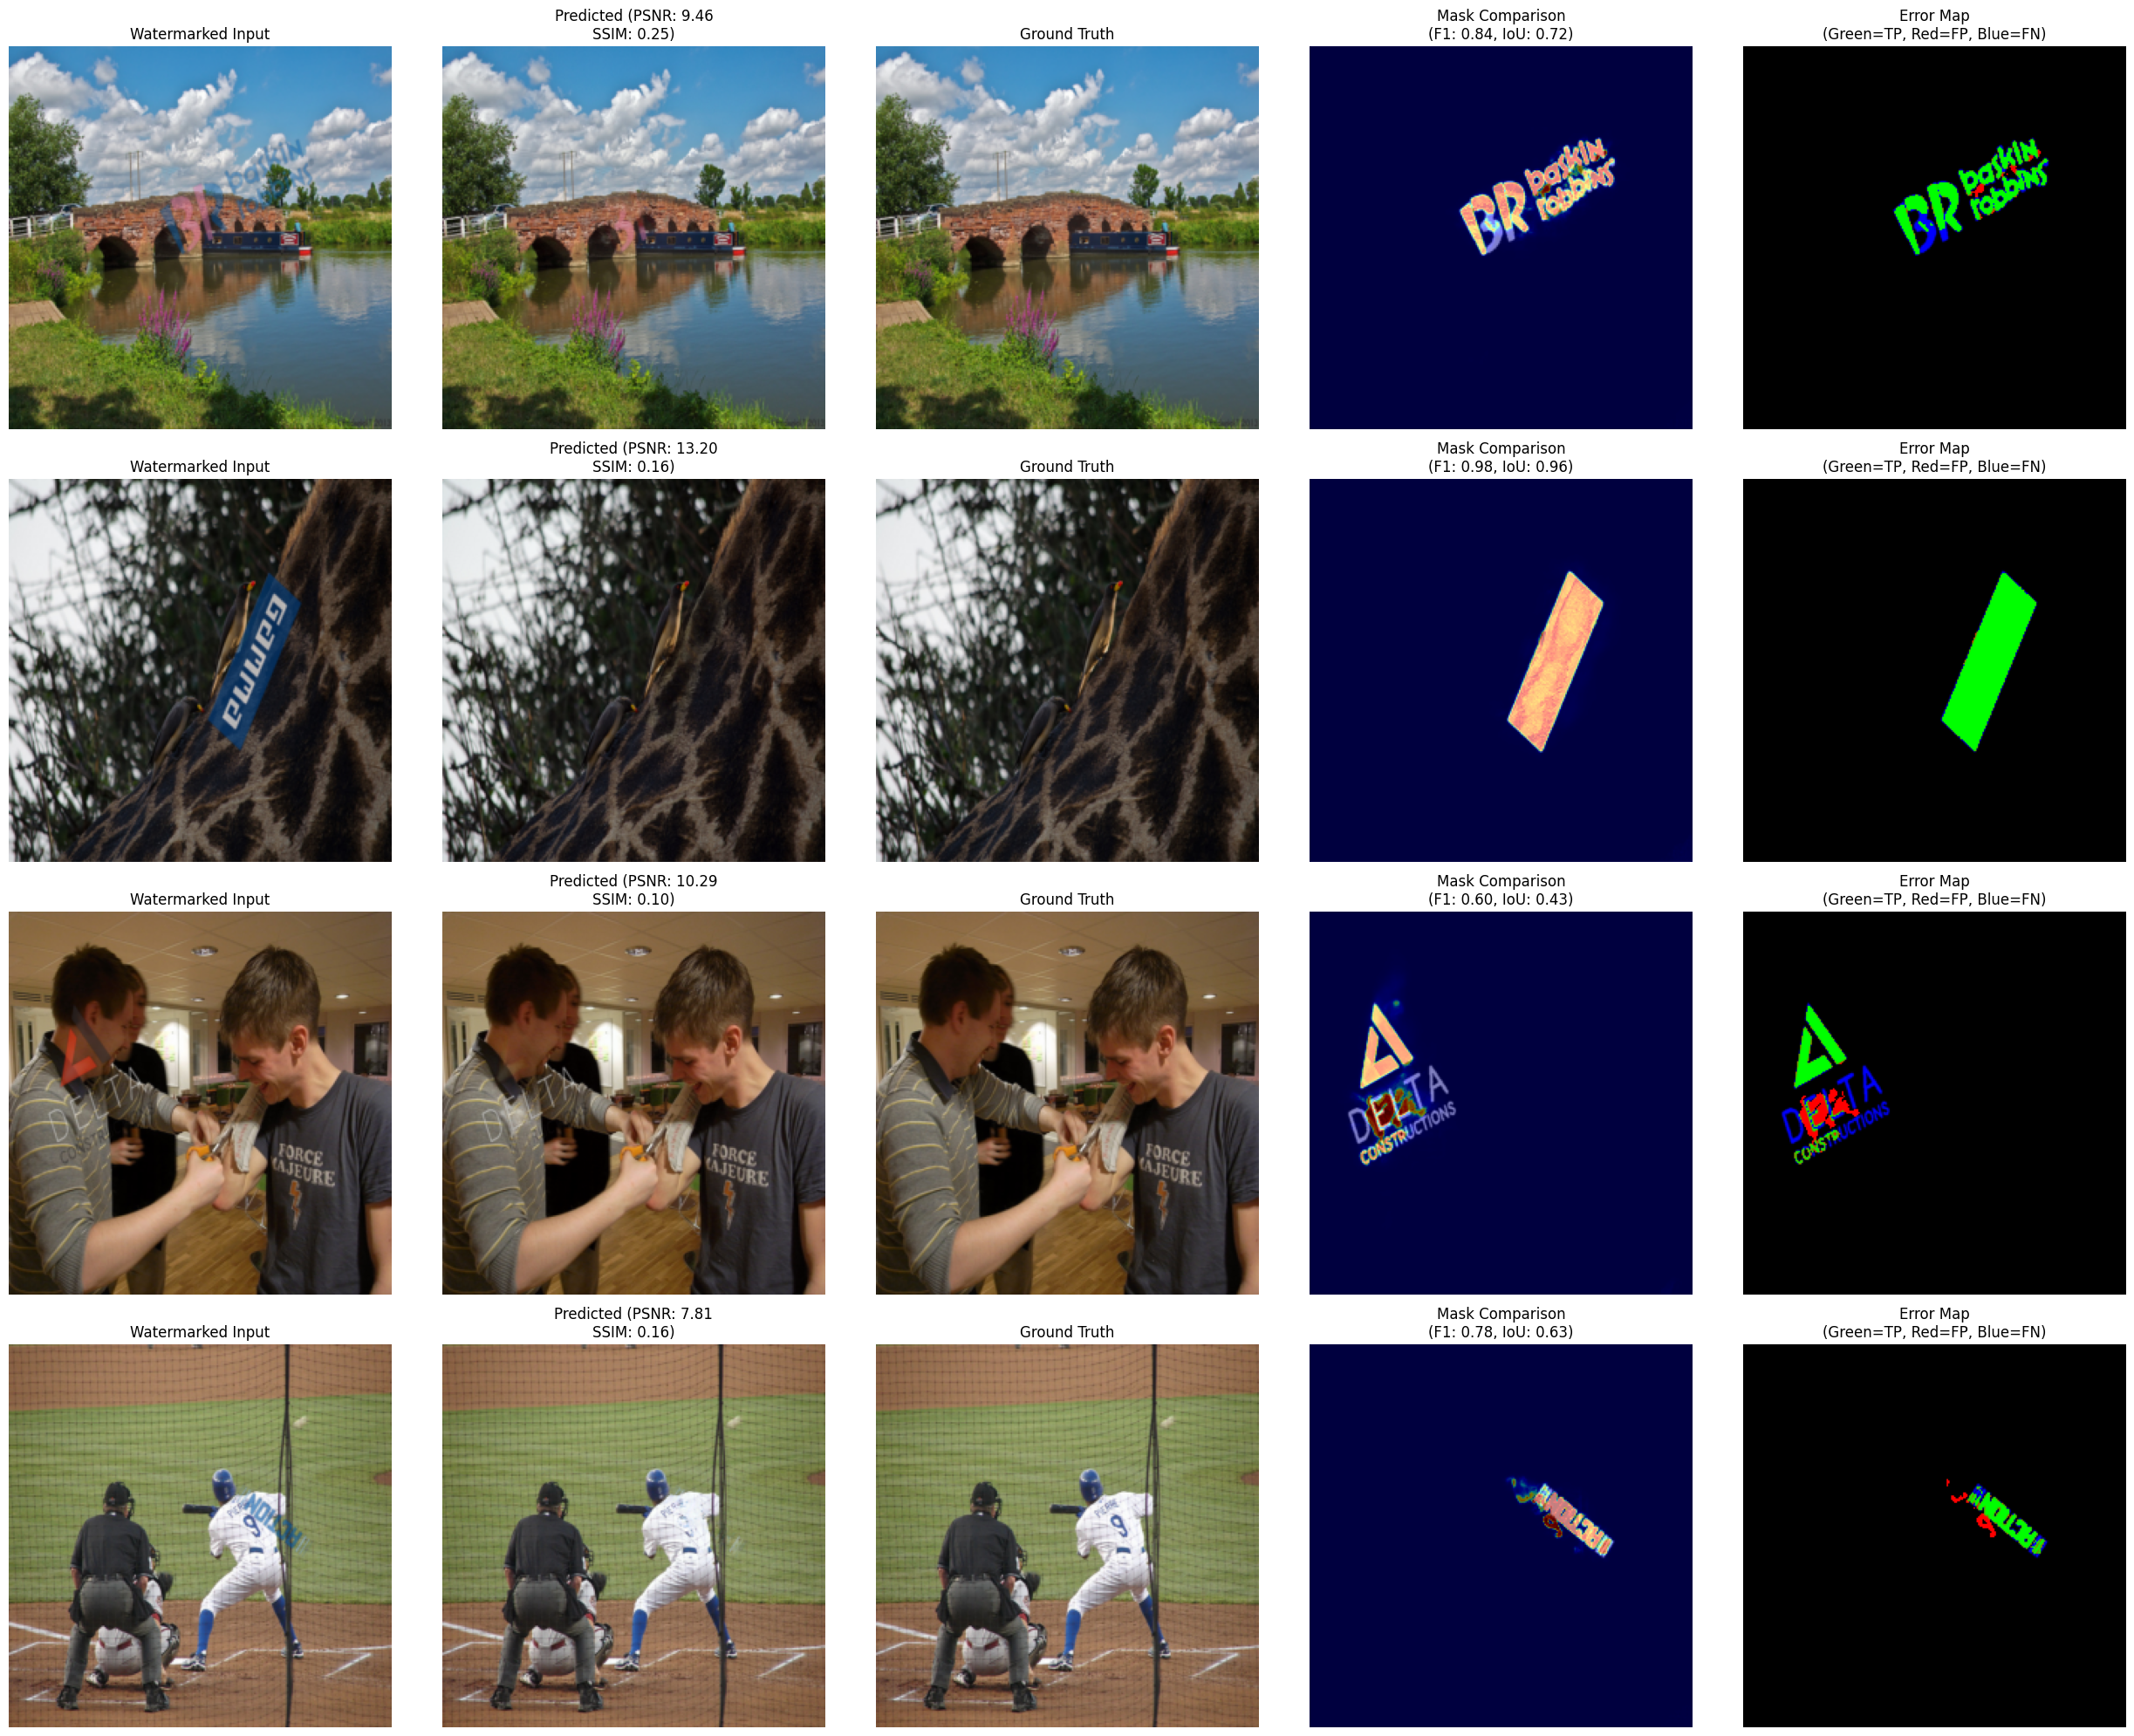

In [12]:
visualize_random_samples(model, val_loader, device, num_samples=4)

In [5]:
from tqdm import tqdm
from lpips import LPIPS

def evaluate_model(model, dataloader, device):
    """
    Evaluate model performance on the provided dataloader and return metrics.
    Processes each item individually for accurate metric computation.
    
    Args:
        model: The model to evaluate
        dataloader: DataLoader containing the evaluation dataset
        device: Device to run evaluation on (e.g., 'cuda' or 'cpu')
    
    Returns:
        Dictionary containing average PSNR, SSIM, LPIPS, F1, and IOU scores
    """
    model.eval()
    psnr_values = []
    ssim_values = []
    lpips_values = []
    f1_values = []
    iou_values = []
    lpips_model = LPIPS(net='alex').to(device)

    with torch.no_grad():
        for batch in tqdm(dataloader):
            J = batch['image'].to(device)
            I = batch['target'].to(device)
            M = batch['mask'].to(device)
            
            # Forward pass
            M_hat, _, _, _, I_hat = model(J)
            
            # Process each item in the batch individually
            batch_size = J.shape[0]
            for i in range(batch_size):
                # Get individual items
                img_pred = denormalize(I_hat[i]).unsqueeze(0).clamp(0, 1)
                img_gt = denormalize(I[i]).unsqueeze(0).clamp(0, 1)
                mask_pred = M_hat[i].unsqueeze(0).squeeze(1)  # [1, H, W]
                mask_gt = M[i].unsqueeze(0).squeeze(1)  # [1, H, W]
                
                # Convert mask probabilities to binary
                mask_pred_binary = (mask_pred > 0.5).float()
                
                # Calculate image metrics
                current_psnr = psnr(img_pred, img_gt)
                current_ssim = ssim(img_pred, img_gt)
                current_lpips = lpips_model(img_pred, img_gt)
                
                # Calculate mask metrics
                intersection = (mask_pred_binary * mask_gt).sum()
                union = (mask_pred_binary + mask_gt).clamp(0, 1).sum()
                
                current_iou = intersection / union
                current_f1 = (2 * intersection) / (mask_pred_binary.sum() + mask_gt.sum())
                
                # Store metrics
                psnr_values.append(current_psnr.item())
                ssim_values.append(current_ssim.item())
                lpips_values.append(current_lpips.item())
                f1_values.append(current_f1.item())
                iou_values.append(current_iou.item())
    
    # Calculate averages
    metrics = {
        'PSNR': sum(psnr_values) / len(psnr_values),
        'SSIM': sum(ssim_values) / len(ssim_values),
        'LPIPS': sum(lpips_values) / len(lpips_values),
        'F1': sum(f1_values) / len(f1_values),
        'IOU': sum(iou_values) / len(iou_values),
    }
    
    return metrics

In [14]:
metrics = evaluate_model(model, val_loader, device)
print(metrics)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


100%|██████████| 507/507 [05:09<00:00,  1.64it/s]

{'PSNR': 38.98598794412154, 'SSIM': 0.9892085244172416, 'LPIPS': 0.010184914519219298, 'F1': 0.7956131147458605, 'IOU': 0.6994683023629242}


In [7]:
def load_model_from_checkpoint(checkpoint_path):
    model = RIRCIModel(simple=False).to(device)
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
    
    return {
        'model': model,
        'optimizer': checkpoint['optimizer_state_dict'],
        'epoch': checkpoint['epoch'],
        'losses': checkpoint['losses']
    }


checkpoint_data = load_model_from_checkpoint(
    '/app/checkpoints/RIRCIModel-2025-05-06-114032/best_model.pth',
)

model = checkpoint_data['model']
model = model.to(device)
model.eval()

metrics = evaluate_model(model, val_loader, device)
print(metrics)

/tmp/ipykernel_5612/507554375.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded checkpoint from epoch 39
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted

Loading model from: /opt/conda/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


  0%|          | 0/507 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `peak_signal_noise_ratio` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `peak_signal_noise_ratio` from `torchmetrics.image` instead.
  _future_warning(
/opt/conda/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(
100%|██████████| 507/507 [04:48<00:00,  1.76it/s]

{'PSNR': 25.193218444488984, 'SSIM': 0.9301149533784292, 'LPIPS': 0.08219555976415079, 'F1': 0.7613139980578896, 'IOU': 0.6599149199110145}


In [9]:
def load_model_from_checkpoint(checkpoint_path):
    model = RIRCIModel(simple=True).to(device)
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
    
    return {
        'model': model,
        'optimizer': checkpoint['optimizer_state_dict'],
        'epoch': checkpoint['epoch'],
        'losses': checkpoint['losses']
    }


checkpoint_data = load_model_from_checkpoint(
    '/app/checkpoints/RIRCIModel-2025-05-08-091428/best_model.pth',
)

model = checkpoint_data['model']
model = model.to(device)
model.eval()

metrics = evaluate_model(model, val_loader, device)
print(metrics)

/tmp/ipykernel_5612/3727444315.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded checkpoint from epoch 68
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted

Loading model from: /opt/conda/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


  0%|          | 0/507 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `peak_signal_noise_ratio` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `peak_signal_noise_ratio` from `torchmetrics.image` instead.
  _future_warning(
/opt/conda/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(
100%|██████████| 507/507 [04:46<00:00,  1.77it/s]

{'PSNR': 38.515760898707796, 'SSIM': 0.9880410022307137, 'LPIPS': 0.012779048390373303, 'F1': 0.0, 'IOU': 0.0}


In [6]:
def load_model_from_checkpoint(checkpoint_path):
    model = RIRCIModel(simple=False).to(device)
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
    
    return {
        'model': model,
        'optimizer': checkpoint['optimizer_state_dict'],
        'epoch': checkpoint['epoch'],
        'losses': checkpoint['losses']
    }


checkpoint_data = load_model_from_checkpoint(
    '/app/checkpoints/RIRCIModel-2025-05-12-075744/best_model.pth',
)

model = checkpoint_data['model']
model = model.to(device)
model.eval()

metrics = evaluate_model(model, val_loader, device)
print(metrics)

/tmp/ipykernel_6424/2760753817.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded checkpoint from epoch 26
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted

Loading model from: /opt/conda/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


  0%|          | 0/507 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `peak_signal_noise_ratio` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `peak_signal_noise_ratio` from `torchmetrics.image` instead.
  _future_warning(
/opt/conda/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(
100%|██████████| 507/507 [04:53<00:00,  1.72it/s]

{'PSNR': 34.37015133002928, 'SSIM': 0.9786306548136248, 'LPIPS': 0.016166938094595105, 'F1': 0.8140492397867432, 'IOU': 0.7183979966791986}
